In [ ]:
import pandas as pd
import numpy as np
import torch
import os
from sklearn.preprocessing import LabelEncoder
import random
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import trange
from sklearn.metrics import roc_auc_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data = np.loadtxt('10000_5.txt').tolist()
random.shuffle(data)

#3824
num_show = 3824

train,test = train_test_split(data,test_size=0.2)


train_inputs = torch.tensor([train[i][:5] for i in range(len(train))], dtype=torch.long)
test_inputs = torch.tensor([test[i][:5] for i in range(len(test))], dtype=torch.long)
train_target = torch.tensor([train[i][5] for i in range(len(train))], dtype=torch.long)
test_target = torch.tensor([test[i][5] for i in range(len(test))], dtype=torch.long)
# out is [batch_size, seq_len, embedding_size]

train_label = torch.from_numpy(np.array([train[i][6] for i in range(len(train))]))
test_label = torch.from_numpy(np.array([test[i][6] for i in range(len(test))]))
train_label = train_label.reshape(-1,1).numpy().tolist()
test_label = test_label.reshape(-1,1).numpy().tolist()

for i in range(len(test_label)):
    if test_label[i][0] ==1:
        test_label[i].append(0)
    if test_label[i][0] ==0:
        test_label[i].append(1)

for i in range(len(train_label)):
    if train_label[i][0] ==1:
        train_label[i].append(0)
    if train_label[i][0] ==0:
        train_label[i].append(1)

train_label = torch.tensor(train_label)
test_label = torch.tensor(test_label)


for item in [train_inputs,test_inputs,train_target,test_target,train_label,test_label]:
    item = item.to(device)

#interest_extract

class Interest_extract(nn.Module):
    def __init__(self):
        super(Interest_extract, self).__init__()
        self.emb = nn.Embedding(num_show, 8)
        self.gru = nn.GRU(input_size=8,hidden_size=8,num_layers=1,batch_first=True)

    def forward(self,train_inputs,train_target,h_0_layer1):
        
    
        train_inputs_emb = self.emb(train_inputs)
        train_inputs_emb = train_inputs_emb.to(device)
        train_target_emb = self.emb(train_target)
        train_target_emb = train_target_emb.to(device)
        gru1_out,h_1_layer1 = self.gru(train_inputs_emb,h_0_layer1)  #lstm(input_data,h_0) 
        gru1_out = gru1_out.to(device)
    #     print(output.size())
    #     print(h_n.size())
    #     print(gru.weight_ih_l0)
    #     print(gru.weight_ih_l0.size())
        return gru1_out, train_inputs_emb,  train_target_emb
    
    #compute auxiliary loss in interest extraction layer
    def compute_auxiliary_loss(self,input_emb,gru1_out,batch_size):

        #flatten batch
        sum_loss = 0

        for m in range(len(input_emb)):
            for n in range(len(input_emb[0])-1):
                while 1:
                    neg_index = random.randint(1,num_show-1)
                    neg_sample = self.emb(torch.tensor(neg_index))
                    if neg_sample.equal(input_emb[m][n+1]) != True:
                        sum_loss += (torch.log(1-torch.sigmoid(gru1_out[m][n].T@neg_sample))+torch.log(torch.sigmoid(gru1_out[m][n].T@input_emb[m][n+1])))
                        break
        return (-1/batch_size)*sum_loss.to(device)


#inin_wei_in_layer2
# gru_weight = torch.nn.GRU(8,8,1)
# random_input = torch.randn(5,50,8) #[seq_len, batch, input_size]
# h_0_layer2 = torch.randn(1,50,8)
# gru2_out,h_1_layer2= gru_weight(random_input,h_0_layer2)
# print(gru2_out.shape,h_1_layer2.shape)
# #inintialize_weight
# weight_inin = []
# for i in range(len(list(gru_weight.named_parameters()))):
#     weight_inin.append(list(gru_weight.named_parameters())[i][1].clone().detach())
# for item in weight_inin:
#     item.requires_grad=True
# import copy
# weight = copy.deepcopy(weight_inin)
# weight.append(torch.randn(8,8))
# del weight_inin

class AU_GRU(nn.Module):
    def __init__(self,weight):
        super(AU_GRU, self).__init__()
        
        self.weight1 = nn.Parameter(weight[0])
        self.weight2 = nn.Parameter(weight[1])
        self.weight3 = nn.Parameter(weight[2])
        self.weight4 = nn.Parameter(weight[3])
        self.att_gate = nn.Parameter(weight[4])
        
#     def compute_gate_value(self, x,item,index,h_t_minus1,hidden_size):
#         r_t = torch.sigmoid(x[item][index]@self.weight1[0:hidden_size].T+self.weight3[0:hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[0:hidden_size].T+self.weight4[0:hidden_size].reshape(1,-1))
#         z_t = torch.sigmoid(x[item][index]@self.weight1[hidden_size:2*hidden_size].T+self.weight3[hidden_size:2*hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[hidden_size:2*hidden_size].T+self.weight4[hidden_size:2*hidden_size].reshape(1,-1))
#         n_t = torch.tanh(x[item][index]@self.weight1[2*hidden_size:3*hidden_size].T+self.weight3[2*hidden_size:3*hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[2*hidden_size:3*hidden_size].T+self.weight4[2*hidden_size:3*hidden_size].reshape(1,-1))
#         h_t = (1-z_t)*n_t + z_t*h_t_minus1
#         return h_t
        
    def forward(self, input,target,batch_size=50,hidden_size=8,seq_len=5):
        x = torch.chunk(input,dim=1,chunks=batch_size)
        h_0_init = torch.chunk(h_0,dim=1,chunks=batch_size)
        #first seperate batchs, than integrate batchs 
        out= torch.zeros(1,1,8)
        for item in range(batch_size):
            h_t = h_0_init[item]
            for index in range(seq_len):
                a = torch.exp(x[item][index]@self.att_gate@target[item].reshape(-1,1))/sum(torch.exp(x[item][i]@self.att_gate@target[item].reshape(-1,1)) for i in range(seq_len))
                h_t_minus1 = h_t
                r_t = torch.sigmoid(x[item][index]@self.weight1[0:hidden_size].T+self.weight3[0:hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[0:hidden_size].T+self.weight4[0:hidden_size].reshape(1,-1))
                z_t = torch.sigmoid(x[item][index]@self.weight1[hidden_size:2*hidden_size].T+self.weight3[hidden_size:2*hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[hidden_size:2*hidden_size].T+self.weight4[hidden_size:2*hidden_size].reshape(1,-1))
                n_t = torch.tanh(x[item][index]@self.weight1[2*hidden_size:3*hidden_size].T+self.weight3[2*hidden_size:3*hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[2*hidden_size:3*hidden_size].T+self.weight4[2*hidden_size:3*hidden_size].reshape(1,-1))
                h_t = (1-a*z_t)*n_t + a*z_t*h_t_minus1
    #             print(h_t,h_t.size())
                out = torch.cat([out,h_t],dim=0)
#         print(out[1:].size())
    #     output = torch.chunk(h_t_tensor[1:],dim=0,chunks=batch_size)   
    #     output = torch.cat([output],dim=1)

#         return torch.cat([out[1:][i:i+seq_len] for i in np.arange(0,len(out[1:]),seq_len)],dim=1)
        return torch.cat([out[1:][i] for i in np.arange(seq_len-1,len(out[1:]),seq_len)],dim=0)


#full-connect

class Concat_layer(nn.Module):
    def __init__(self,d_in,hidden1,hidden2,d_out):
        super(Concat_layer, self).__init__()
        self.linear1 = nn.Linear(d_in,hidden1)
        self.linear2 = nn.Linear(hidden1,hidden2)
        self.linear3 = nn.Linear(hidden2,d_out)
  
    def forward(self, x):
        out = self.linear1(x)
        out = dice(out,1,200)
        out = self.linear2(out)
        out = dice(out,1,80)
        out = self.linear3(out)
        soft = nn.Softmax(dim=1)
        out = soft(out)
        return out
    
def dice(x,alpha,dim):
    BN = nn.BatchNorm1d(dim)
    x_p = torch.sigmoid(BN(x))
    return alpha*(1.0-x_p) * x + x_p * x


#initialize weight layer loss


#inin_wei_in_layer2
gru_weight = torch.nn.GRU(8,8,1)
random_input = torch.randn(5,50,8) #[seq_len, batch, input_size]
h_0_layer2 = torch.randn(1,50,8)
gru2_out,h_1_layer2= gru_weight(random_input,h_0_layer2)
# print(gru2_out.shape,h_1_layer2.shape)
#inintialize_weight
weight_inin = []
for i in range(len(list(gru_weight.named_parameters()))):
    weight_inin.append(list(gru_weight.named_parameters())[i][1].clone().detach())
for item in weight_inin:
    item.requires_grad=True
import copy
weight = copy.deepcopy(weight_inin)
weight.append(torch.randn(8,8))
del weight_inin
for item in weight:
    item = item.to(device)

layer1 = Interest_extract()
layer2 = AU_GRU(weight)
layer3 = Concat_layer(16,200,80,2)

layer1gpu = layer1.to(device)
layer2gpu = layer2.to(device)
layer3gpu = layer3.to(device)


#loss_auxi = compute_auxiliary_loss(train_inputs_emb[:20],gru1_out,20)
criterion_fin = torch.nn.BCELoss(reduction='mean')

optimizer1 = torch.optim.SGD(layer1.parameters(), lr=1e-2)
optimizer2 = torch.optim.SGD(layer2.parameters(), lr=1e-2)
optimizer3 = torch.optim.SGD(layer3.parameters(), lr=1e-4)


h_0_layer1 = torch.randn(1,50,8)
h_0_layer1 = h_0_layer1.to(device)
h_0 = torch.randn(1,50,8)
h_0 = h_0.cuda

#train for one batch
def train(train_inputs,train_target,train_label,batch_size):

    gru1_out, train_inputs_emb, train_target_emb = layer1gpu.forward(train_inputs,train_target,h_0_layer1)
    #batch_loss for layer1
    loss_auxi = layer1gpu.compute_auxiliary_loss(train_inputs_emb,gru1_out,batch_size)
    train_loss1.append(loss_auxi.cpu().tolist())
    optimizer1.zero_grad()
    layer1gpu.emb.weight.grad = torch.autograd.grad(loss_auxi,layer1gpu.emb.weight,retain_graph=True)[0]
    layer1gpu.gru.weight_ih_l0.grad = torch.autograd.grad(loss_auxi,layer1gpu.gru.weight_ih_l0,retain_graph=True)[0]
    layer1gpu.gru.weight_hh_l0.grad = torch.autograd.grad(loss_auxi,layer1gpu.gru.weight_hh_l0,retain_graph=True)[0]
    layer1gpu.gru.bias_ih_l0.grad = torch.autograd.grad(loss_auxi,layer1gpu.gru.bias_ih_l0,retain_graph=True)[0]
    layer1gpu.gru.bias_hh_l0.grad = torch.autograd.grad(loss_auxi,layer1gpu.gru.bias_hh_l0)[0]
    optimizer1.step()

    gru1_out = gru1_out.transpose(0,1)
    gru2_out = layer2gpu.forward(gru1_out,train_target_emb)

    y_ = train_label.float()
    y_pred = layer3gpu.forward(torch.cat([gru2_out,train_target_emb],dim=1))

    # compute loss
    loss = criterion_fin(y_pred, y_)
    train_loss2.append(loss.cpu().tolist())
#         print("AUC", roc_auc_score(y_.detach().numpy(), y_pred.detach().numpy()))
    train_auc.append(roc_auc_score(y_.cpu().detach().numpy(), y_pred.cpu().detach().numpy()).tolist())
    # backward,update parameters
    optimizer3.zero_grad()
    optimizer2.zero_grad()
    layer3gpu.linear1.weight.grad = torch.autograd.grad(loss,layer3gpu.linear1.weight,retain_graph=True)[0]
    layer3gpu.linear1.bias.grad = torch.autograd.grad(loss,layer3gpu.linear1.bias,retain_graph=True)[0]
    layer3gpu.linear2.weight.grad = torch.autograd.grad(loss,layer3gpu.linear2.weight,retain_graph=True)[0]
    layer3gpu.linear2.bias.grad = torch.autograd.grad(loss,layer3gpu.linear2.bias,retain_graph=True)[0]
    layer3gpu.linear3.weight.grad = torch.autograd.grad(loss,layer3gpu.linear3.weight,retain_graph=True)[0]
    layer3gpu.linear3.bias.grad = torch.autograd.grad(loss,layer3gpu.linear3.bias,retain_graph=True)[0]


    layer2gpu.weight1.grad = torch.autograd.grad(loss,layer2gpu.weight1,retain_graph=True)[0]
    layer2gpu.weight2.grad = torch.autograd.grad(loss,layer2gpu.weight2,retain_graph=True)[0]
    layer2gpu.weight3.grad = torch.autograd.grad(loss,layer2gpu.weight3,retain_graph=True)[0]
    layer2gpu.weight4.grad = torch.autograd.grad(loss,layer2gpu.weight4,retain_graph=True)[0]
    layer2gpu.att_gate.grad = torch.autograd.grad(loss,layer2gpu.att_gate)[0]       
    optimizer3.step()
    optimizer2.step()
#         print('loss_auxi:',loss_auxi,"loss:",loss)

def test(test_inputs,test_target,test_label,batch_size):
    for item in [test_inputs,test_target,test_label]:
        item = item.to(device)
    gru1_out, test_inputs_emb, test_target_emb = layer1.forward(test_inputs,test_target,h_0_layer1)
    #batch_loss for layer1
    loss_auxi = layer1.compute_auxiliary_loss(test_inputs_emb,gru1_out,batch_size)
    test_loss1.append(loss_auxi.cpu().tolist())

    gru1_out = gru1_out.transpose(0,1)
    gru2_out = layer2.forward(gru1_out,test_target_emb)

    y_ = test_label.float()
    y_pred = layer3gpu.forward(torch.cat([gru2_out,test_target_emb],dim=1))

    loss = criterion_fin(y_pred, y_)
    test_loss2.append(loss.cpu().tolist())
#         print("AUC", roc_auc_score(y_.detach().numpy(), y_pred.detach().numpy()))
    test_auc.append(roc_auc_score(y_.cpu().detach().numpy(), y_pred.cpu().detach().numpy()).tolist())



batch_size = 50
#epoch_size
train_loss1 = []
train_loss2 = []
train_auc = []
test_loss1 = []
test_loss2 = []
test_auc = []
for i in trange(20):
    for j in np.arange(0,305000,batch_size):
        for item in [train_inputs[j:j+batch_size],train_target[j:j+batch_size],train_label[j:j+batch_size]]:
            item = item.cuda()
        train(train_inputs[j:j+batch_size],train_target[j:j+batch_size],train_label[j:j+batch_size],batch_size)
        
    for j in np.arange(0,75500,batch_size):
        for item in [test_inputs[j:j+batch_size],test_target[j:j+batch_size],test_label[j:j+batch_size]]:
            item = item.cuda()
        test(test_inputs[j:j+batch_size],test_target[j:j+batch_size],test_label[j:j+batch_size],batch_size)
        
d = pd.DataFrame([train_loss1,train_loss2,train_auc]).T
d.rename(columns={0:'LOSS1',1:'LOSS2',2:'AUC'},inplace=True)
d.to_csv('train_result_gpu.csv',index=False)
d1 = pd.DataFrame([test_loss1,test_loss2,test_auc]).T
d1.rename(columns={0:'LOSS1',1:'LOSS2',2:'AUC'},inplace=True)
d1.to_csv('test_result_gpu.csv',index=False)


In [1]:
# -*- coding: utf-8 -*  
import pandas as pd
import numpy as np
import torch
import os
from sklearn.preprocessing import LabelEncoder
import random
from torch.autograd import Variable
from torch import nn
from torch.autograd import Variable
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import trange
from sklearn.metrics import roc_auc_score

data = np.loadtxt('10000_5.txt').tolist()
random.shuffle(data)

#3824
num_show = 3824

train,test = train_test_split(data,test_size=0.2)

# embedding的输入要求必需是torch.long类型的,[batch_size, seq_len]

train_inputs = torch.tensor([train[i][:5] for i in range(len(train))], dtype=torch.long)
test_inputs = torch.tensor([test[i][:5] for i in range(len(test))], dtype=torch.long)
train_target = torch.tensor([train[i][5] for i in range(len(train))], dtype=torch.long)
test_target = torch.tensor([test[i][5] for i in range(len(test))], dtype=torch.long)
# 输出是[batch_size, seq_len, embedding_size]

train_label = torch.from_numpy(np.array([train[i][6] for i in range(len(train))]))
test_label = torch.from_numpy(np.array([test[i][6] for i in range(len(test))]))
train_label = train_label.reshape(-1,1).numpy().tolist()
test_label = test_label.reshape(-1,1).numpy().tolist()

for i in range(len(test_label)):
    if test_label[i][0] ==1:
        test_label[i].append(0)
    if test_label[i][0] ==0:
        test_label[i].append(1)

for i in range(len(train_label)):
    if train_label[i][0] ==1:
        train_label[i].append(0)
    if train_label[i][0] ==0:
        train_label[i].append(1)

train_label = torch.tensor(train_label)
test_label = torch.tensor(test_label)
#兴趣挖掘层

for item in [train_inputs,test_inputs,train_target,test_target,train_label,test_label]:
    item = item.cuda()

class Interest_extract(nn.Module):
    def __init__(self):
        super(Interest_extract, self).__init__()
        self.emb = nn.Embedding(num_show, 8)
        self.gru = nn.GRU(input_size=8,hidden_size=8,num_layers=1,batch_first=True)
        
    def forward(self,train_inputs,test_inputs,train_target,test_target,h_0_layer1):
        
        #初始隐状态
        #层数乘以方向(单项为1，双向为2)，批量，输出的维度hidden
        #输出变量
        train_inputs_emb = self.emb(train_inputs)
        test_inputs_emb = self.emb(test_inputs)
        train_target_emb = self.emb(train_target)
        test_target_emb = self.emb(test_target)
        gru1_out,h_1_layer1 = self.gru(train_inputs_emb,h_0_layer1)  #lstm(input_data,h_0) 不定义初始隐状态默认为0
    #     print(output.size())
    #     print(h_n.size())
    #     print(gru.weight_ih_l0)
    #     print(gru.weight_ih_l0.size())
        return gru1_out, train_inputs_emb, test_inputs_emb, train_target_emb, test_target_emb
    
    #compute auxiliary loss in interest extraction layer
    def compute_auxiliary_loss(self,input_emb,gru1_out,batch_size):

        #flatten batch
        sum_loss = 0

        for m in range(len(input_emb)):
            for n in range(len(input_emb[0])-1):
                while 1:
                    neg_index = random.randint(1,num_show-1)
                    neg_sample = self.emb(torch.tensor(neg_index))
                    if neg_sample.equal(input_emb[m][n+1]) != True:
                        sum_loss += (torch.log(1-torch.sigmoid(gru1_out[m][n].T.matmul(neg_sample)))+torch.log(torch.sigmoid(gru1_out[m][n].T.matmul(input_emb[m][n+1]))))
                        break
        return (-1/batch_size)*sum_loss

#兴趣演化层

#inin_wei_in_layer2
gru_weight = torch.nn.GRU(8,8,1)
random_input = torch.randn(5,50,8) #[seq_len, batch, input_size]
h_0_layer2 = torch.randn(1,50,8)
gru2_out,h_1_layer2= gru_weight(random_input,h_0_layer2)
# print(gru2_out.shape,h_1_layer2.shape)
#inintialize_weight
weight_inin = []
for i in range(len(list(gru_weight.named_parameters()))):
    weight_inin.append(list(gru_weight.named_parameters())[i][1].clone().detach())
for item in weight_inin:
    item.requires_grad=True
import copy
weight = copy.deepcopy(weight_inin)
weight.append(torch.randn(8,8))
del weight_inin
for item in weight:
    item = item.cuda()

class AU_GRU(nn.Module):
    def __init__(self,weight):
        super(AU_GRU, self).__init__()
        
        self.weight1 = nn.Parameter(weight[0])
        self.weight2 = nn.Parameter(weight[1])
        self.weight3 = nn.Parameter(weight[2])
        self.weight4 = nn.Parameter(weight[3])
        self.att_gate = nn.Parameter(weight[4])

#     def compute_gate_value(self, x,item,index,h_t_minus1,hidden_size):
#         r_t = torch.sigmoid(x[item][index]@self.weight1[0:hidden_size].T+self.weight3[0:hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[0:hidden_size].T+self.weight4[0:hidden_size].reshape(1,-1))
#         z_t = torch.sigmoid(x[item][index]@self.weight1[hidden_size:2*hidden_size].T+self.weight3[hidden_size:2*hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[hidden_size:2*hidden_size].T+self.weight4[hidden_size:2*hidden_size].reshape(1,-1))
#         n_t = torch.tanh(x[item][index]@self.weight1[2*hidden_size:3*hidden_size].T+self.weight3[2*hidden_size:3*hidden_size].reshape(1,-1)+h_t_minus1@self.weight2[2*hidden_size:3*hidden_size].T+self.weight4[2*hidden_size:3*hidden_size].reshape(1,-1))
#         h_t = (1-z_t)*n_t + z_t*h_t_minus1
#         return h_t
        
    def forward(self, input,target,batch_size=50,hidden_size=8,seq_len=5):
        x = torch.chunk(input,dim=1,chunks=batch_size)
        h_0_init = torch.chunk(h_0,dim=1,chunks=batch_size)
        #先分开批量，后合并批量
        out= torch.zeros(1,1,8)
        for item in range(batch_size):
            h_t = h_0_init[item]
            for index in range(seq_len):
                a = torch.exp(x[item][index].matmul(self.att_gate).matmul(target[item]).reshape(-1,1))/sum(torch.exp(x[item][i].matmul(self.att_gate).matmul(target[item]).reshape(-1,1)) for i in range(seq_len))
                h_t_minus1 = h_t
                r_t = torch.sigmoid(x[item][index].matmul(self.weight1[0:hidden_size].T)+self.weight3[0:hidden_size].reshape(1,-1)+h_t_minus1.matmul(self.weight2[0:hidden_size].T)+self.weight4[0:hidden_size].reshape(1,-1))
                z_t = torch.sigmoid(x[item][index].matmul(self.weight1[hidden_size:2*hidden_size].T)+self.weight3[hidden_size:2*hidden_size].reshape(1,-1)+h_t_minus1.matmul(self.weight2[hidden_size:2*hidden_size].T)+self.weight4[hidden_size:2*hidden_size].reshape(1,-1))
                n_t = torch.tanh(x[item][index].matmul(self.weight1[2*hidden_size:3*hidden_size].T)+self.weight3[2*hidden_size:3*hidden_size].reshape(1,-1)+h_t_minus1.matmul(self.weight2[2*hidden_size:3*hidden_size].T)+self.weight4[2*hidden_size:3*hidden_size].reshape(1,-1))
                h_t = (1-a*z_t)*n_t + a*z_t*h_t_minus1
    #             print(h_t,h_t.size())
                out = torch.cat([out,h_t],dim=0)
#         print(out[1:].size())
    #     output = torch.chunk(h_t_tensor[1:],dim=0,chunks=batch_size)   
    #     output = torch.cat([output],dim=1)

#         return torch.cat([out[1:][i:i+seq_len] for i in np.arange(0,len(out[1:]),seq_len)],dim=1)
        return torch.cat([out[1:][i] for i in np.arange(seq_len-1,len(out[1:]),seq_len)],dim=0)


#全连接层

class Concat_layer(nn.Module):
    def __init__(self,d_in,hidden1,hidden2,d_out):
        super(Concat_layer, self).__init__()
        self.linear1 = nn.Linear(d_in,hidden1)
        self.linear2 = nn.Linear(hidden1,hidden2)
        self.linear3 = nn.Linear(hidden2,d_out)
  
    def forward(self, x):
        out = self.linear1(x)
        out = dice(out,1,200)
        out = self.linear2(out)
        out = dice(out,1,80)
        out = self.linear3(out)
        soft = nn.Softmax(dim=1)
        out = soft(out)
        return out
    
def dice(x,alpha,dim):
    BN = nn.BatchNorm1d(dim)
    x_p = torch.sigmoid(BN(x))
    return alpha*(1.0-x_p) * x + x_p * x


#权重初始化、模型、损失函数、优化器

h_0_layer1 = torch.randn(1,50,8)
h_0 = torch.randn(1,50,8)


#inin_wei_in_layer2
gru_weight = torch.nn.GRU(8,8,1)
random_input = torch.randn(5,50,8) #[seq_len, batch, input_size]
h_0_layer2 = torch.randn(1,50,8)
gru2_out,h_1_layer2= gru_weight(random_input,h_0_layer2)
# print(gru2_out.shape,h_1_layer2.shape)
#inintialize_weight
weight_inin = []
for i in range(len(list(gru_weight.named_parameters()))):
    weight_inin.append(list(gru_weight.named_parameters())[i][1].clone().detach())
for item in weight_inin:
    item.requires_grad=True
import copy
weight = copy.deepcopy(weight_inin)
weight.append(torch.randn(8,8))
del weight_inin

layer1 = Interest_extract()
layer2 = AU_GRU(weight)
layer3 = Concat_layer(16,200,80,2)

layer1 = layer1.cuda()
layer2 = layer2.cuda()
layer3 = layer3.cuda()

#loss_auxi = compute_auxiliary_loss(train_inputs_emb[:20],gru1_out,20)
criterion_fin = torch.nn.BCELoss(reduction='mean')
criterion_fin = criterion_fin.cuda()

optimizer1 = torch.optim.SGD(layer1.parameters(), lr=1e-2)
optimizer2 = torch.optim.SGD(layer2.parameters(), lr=1e-2)
optimizer3 = torch.optim.SGD(layer3.parameters(), lr=1e-4)


#train for one batch
def train(train_inputs,train_target,train_label,batch_size):

    gru1_out, train_inputs_emb, test_inputs_emb, train_target_emb, test_target_emb = layer1.forward(train_inputs,test_inputs,train_target,test_target,h_0_layer1)
    #batch_loss for layer1
    loss_auxi = layer1.compute_auxiliary_loss(train_inputs_emb,gru1_out,batch_size)
    loss1.append(loss_auxi.cpu().tolist())
    optimizer1.zero_grad()
    layer1.emb.weight.grad = torch.autograd.grad(loss_auxi,layer1.emb.weight,retain_graph=True)[0]
    layer1.gru.weight_ih_l0.grad = torch.autograd.grad(loss_auxi,layer1.gru.weight_ih_l0,retain_graph=True)[0]
    layer1.gru.weight_hh_l0.grad = torch.autograd.grad(loss_auxi,layer1.gru.weight_hh_l0,retain_graph=True)[0]
    layer1.gru.bias_ih_l0.grad = torch.autograd.grad(loss_auxi,layer1.gru.bias_ih_l0,retain_graph=True)[0]
    layer1.gru.bias_hh_l0.grad = torch.autograd.grad(loss_auxi,layer1.gru.bias_hh_l0)[0]
    optimizer1.step()

    gru1_out = gru1_out.transpose(0,1)
    gru2_out = layer2.forward(gru1_out,train_target_emb)

    y_ = train_label.float()
    y_pred = layer3.forward(torch.cat([gru2_out,train_target_emb],dim=1))

    # 计算损失
    loss = criterion_fin(y_pred, y_)
    loss2.append(loss.cpu().tolist())
#         print("AUC", roc_auc_score(y_.detach().numpy(), y_pred.detach().numpy()))
    auc.append(roc_auc_score(y_.cpu().detach().numpy(), y_pred.cpu().detach().numpy()).tolist())
    # 反向传播, 更新参数
    optimizer3.zero_grad()
    optimizer2.zero_grad()
    layer3.linear1.weight.grad = torch.autograd.grad(loss,layer3.linear1.weight,retain_graph=True)[0]
    layer3.linear1.bias.grad = torch.autograd.grad(loss,layer3.linear1.bias,retain_graph=True)[0]
    layer3.linear2.weight.grad = torch.autograd.grad(loss,layer3.linear2.weight,retain_graph=True)[0]
    layer3.linear2.bias.grad = torch.autograd.grad(loss,layer3.linear2.bias,retain_graph=True)[0]
    layer3.linear3.weight.grad = torch.autograd.grad(loss,layer3.linear3.weight,retain_graph=True)[0]
    layer3.linear3.bias.grad = torch.autograd.grad(loss,layer3.linear3.bias,retain_graph=True)[0]


    layer2.weight1.grad = torch.autograd.grad(loss,layer2.weight1,retain_graph=True)[0]
    layer2.weight2.grad = torch.autograd.grad(loss,layer2.weight2,retain_graph=True)[0]
    layer2.weight3.grad = torch.autograd.grad(loss,layer2.weight3,retain_graph=True)[0]
    layer2.weight4.grad = torch.autograd.grad(loss,layer2.weight4,retain_graph=True)[0]
    layer2.att_gate.grad = torch.autograd.grad(loss,layer2.att_gate)[0]       
    optimizer3.step()
    optimizer2.step()
#         print('loss_auxi:',loss_auxi,"loss:",loss)


batch_size = 50
#epoch_size
loss1 = []
loss2 = []
auc = []

for i in trange(5):
    for j in np.arange(0,300000,batch_size):
        train(train_inputs[j:j+batch_size],train_target[j:j+batch_size],train_label[j:j+batch_size],batch_size)
for i in trange(20):
    for j in np.arange(0,75000,batch_size):
        train(test_inputs[j:j+batch_size],test_target[j:j+batch_size],test_label[j:j+batch_size],batch_size)
d = pd.DataFrame([loss1,loss2,auc]).T
d.rename(columns={0:'LOSS1',1:'LOSS2',2:'AUC'},inplace=True)
d.to_csv('result_gpu.csv',index=False)


OSError: D:/推荐数据集/10000_5.txt not found.

In [8]:
torch.__version__

'1.7.1+cpu'

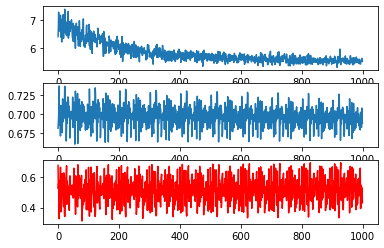

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
x = np.arange(len(loss1))
ax1 = fig.add_subplot(3,1,1)
ax1.plot(x[:1000],loss1[:1000])
ax1 = fig.add_subplot(3,1,2)
ax1.plot(x[:1000],loss2[:1000])
ax1 = fig.add_subplot(3,1,3)
ax1.plot(x[:1000],auc[:1000],color='red')